In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

In [2]:
useful_trips = pd.read_csv('./features_per_trip_useful.csv')

In [3]:
useful_trips.shape

(263106, 12)

In [4]:
data_path = './../data_cabspotting/'

file_paths = glob.glob(data_path + 'processed_*.csv')

dfs = []

for file_path in tqdm(file_paths):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        dfs.append(df)
        
df_full = pd.concat(dfs, axis=0, ignore_index=True)

100%|██████████████████████████████████████████████████████████████| 536/536 [00:06<00:00, 77.85it/s]


In [5]:
useful_trips_ids = useful_trips[['driver','trip_id']]
df_full_utils = df_full.merge(useful_trips_ids, on=['driver','trip_id'], how='inner')

In [6]:
df_full_utils = df_full_utils.sort_values(by=['driver','trip_id','3'])

In [7]:
latmax = 37.81
latmin = 37.7

lonmax = -122.375
lonmin = -122.52

In [8]:
df_full_utils = df_full_utils[(df_full_utils['0']>latmin) & (df_full_utils['0']<latmax) & (df_full_utils['1']>lonmin) & (df_full_utils['1']<lonmax)]

In [9]:
df_full_utils['3'] = pd.to_datetime(df_full_utils['3'])

In [10]:
threshold = 0.2 # to interpolate

def interpolate_points_and_dates(start, end, n):
    lat_diff = (end[0] - start[0]) / (n + 1)
    lon_diff = (end[1] - start[1]) / (n + 1)
    date_diff = (end[2] - start[2]) / (n + 1)
    
    interpolated = [(start[0] + i * lat_diff, start[1] + i * lon_diff, start[2] + i * date_diff) for i in range(1, n + 1)]
    return interpolated

# Interpolate for each group
result = []
for _, group in tqdm(df_full_utils.groupby(['trip_id', 'driver'])):
    prev_row = None
    for _, row in group.iterrows():
        if prev_row is not None:
            # Calculate number of points needed based on distance and threshold
            num_points = int(row['distance_km'] / threshold) - 1
            if num_points > 0:
                # Interpolate between prev_row and current row
                interpolated = interpolate_points_and_dates((prev_row['0'], prev_row['1'], prev_row['3']), (row['0'], row['1'], row['3']), num_points)
                for lat, lon, date in interpolated:
                    result.append({'0': lat, '1': lon, 'trip_id': row['trip_id'], 'driver': row['driver'], '3': date})
        result.append(row.to_dict())
        prev_row = row

# Convert result to DataFrame
interpolated_df = pd.DataFrame(result)

100%|███████████████████████████████████████████████████████| 254190/254190 [04:17<00:00, 988.46it/s]


In [11]:
def check_cell_density(args):
    """
    Helper function to check the density of points in a grid cell.
    """
    points_array, lat_start, lat_end, lon_start, lon_end, density_threshold = args

    in_cell = points_array[
        (points_array[:, 0] >= lat_start) & 
        (points_array[:, 0] < lat_end) & 
        (points_array[:, 1] >= lon_start) & 
        (points_array[:, 1] < lon_end)
    ]

    if len(in_cell) >= density_threshold:
        node_center = (np.mean(in_cell[:, 0]), np.mean(in_cell[:, 1]))  # Average point of the assigned points
        return node_center, in_cell
    else:
        return None, []

def create_nodes_from_points_parallel(points, grid_resolution, density_threshold):
    """
    Create nodes from latitude and longitude points using a grid-based approach in parallel.
    Also, return a DataFrame that assigns each location to a node.
    """
    points_array = np.array(points)

    lat_min, lat_max = np.min(points_array[:, 0]), np.max(points_array[:, 0])
    lon_min, lon_max = np.min(points_array[:, 1]), np.max(points_array[:, 1])

    lat_cells = int((lat_max - lat_min) / grid_resolution)
    lon_cells = int((lon_max - lon_min) / grid_resolution)

    args_list = []
    for i in range(lat_cells):
        for j in range(lon_cells):
            lat_start, lat_end = lat_min + i * grid_resolution, lat_min + (i + 1) * grid_resolution
            lon_start, lon_end = lon_min + j * grid_resolution, lon_min + (j + 1) * grid_resolution
            args_list.append((points_array, lat_start, lat_end, lon_start, lon_end, density_threshold))

    with Pool(cpu_count()) as pool:
        results = pool.map(check_cell_density, args_list)

    nodes = [result[0] for result in results if result[0] is not None]
    assigned_points = [result[1] for result in results if result[0] is not None]

    # Flatten the list of assigned points and create a DataFrame
    all_assigned_points = np.vstack(assigned_points)
    df = pd.DataFrame(all_assigned_points, columns=['Latitude', 'Longitude'])

    # Assign each location to its node
    df['node_lat'] = [lat for sublist in [[node[0]] * len(points) for node, points in zip(nodes, assigned_points)] for lat in sublist]
    df['node_lon'] = [lon for sublist in [[node[1]] * len(points) for node, points in zip(nodes, assigned_points)] for lon in sublist]

    return nodes, df

In [12]:
grid_resolution = 0.006
density_threshold = 100

nodes, df_nodes_location = create_nodes_from_points_parallel(np.array(interpolated_df[['0', '1']]), grid_resolution, density_threshold)

In [13]:
len(nodes)

355

In [14]:
df_nodes_location = df_nodes_location.drop_duplicates()
df_nodes_location['node_id'] = df_nodes_location.groupby(['node_lat','node_lon']).ngroup()

(-122.52, -122.375)

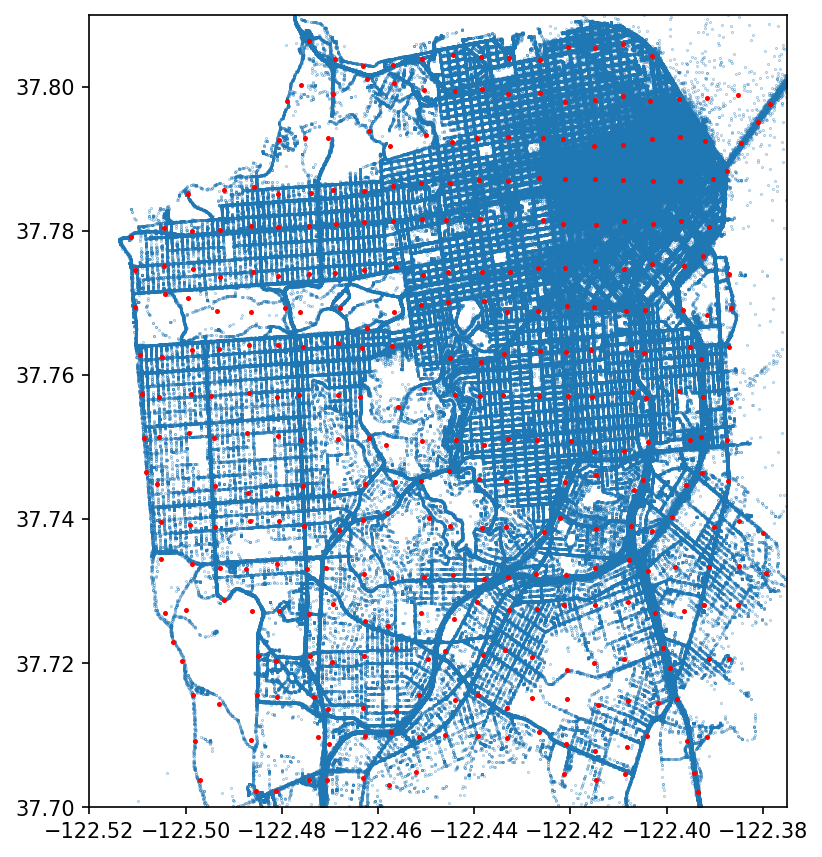

In [15]:
fig, ax = plt.subplots(figsize=(6,7), dpi=150)
ax.scatter(df_full_utils['1'], df_full_utils['0'], s = 0.03)
ax.scatter(np.array(nodes)[:,1], np.array(nodes)[:,0], color='red', s=2)
ax.set_ylim(latmin, latmax)
ax.set_xlim(lonmin, lonmax)

In [16]:
df_nodes = pd.DataFrame(nodes, columns=['node_lat', 'node_lon'])

In [17]:
df_nodes_location['node_id'] = df_nodes_location.groupby(['node_lat','node_lon']).ngroup()

In [18]:
df_nodes_location = df_nodes_location.drop_duplicates()

In [19]:
df_nodes_location

,Latitude,Longitude,node_lat,node_lon,node_id
0,37.705882,-122.497767,37.703864,-122.497041,7
1,37.703990,-122.497600,37.703864,-122.497041,7
2,37.705740,-122.498160,37.703864,-122.497041,7
3,37.704080,-122.497540,37.703864,-122.497041,7
4,37.705923,-122.497816,37.703864,-122.497041,7
...,...,...,...,...,...
6991260,37.803520,-122.403230,37.804326,-122.403073,349
6991261,37.804860,-122.404590,37.804326,-122.403073,349
6991262,37.805640,-122.405640,37.804326,-122.403073,349
6991263,37.805720,-122.405680,37.804326,-122.403073,349


In [20]:
interpolated_df = interpolated_df.rename(columns={'0':'Latitude','1':'Longitude'})

In [21]:
interpolated_df.shape

(7011257, 8)

In [22]:
interpolated_df_full = interpolated_df.copy()

In [23]:
interpolated_df = interpolated_df.merge(df_nodes_location, on=['Latitude','Longitude'], how='inner')

In [24]:
interpolated_df = interpolated_df[interpolated_df.groupby(['driver','trip_id']).Latitude.transform('count')>20]

In [25]:
interpolated_df.shape

(5256467, 11)

(-122.52, -122.375)

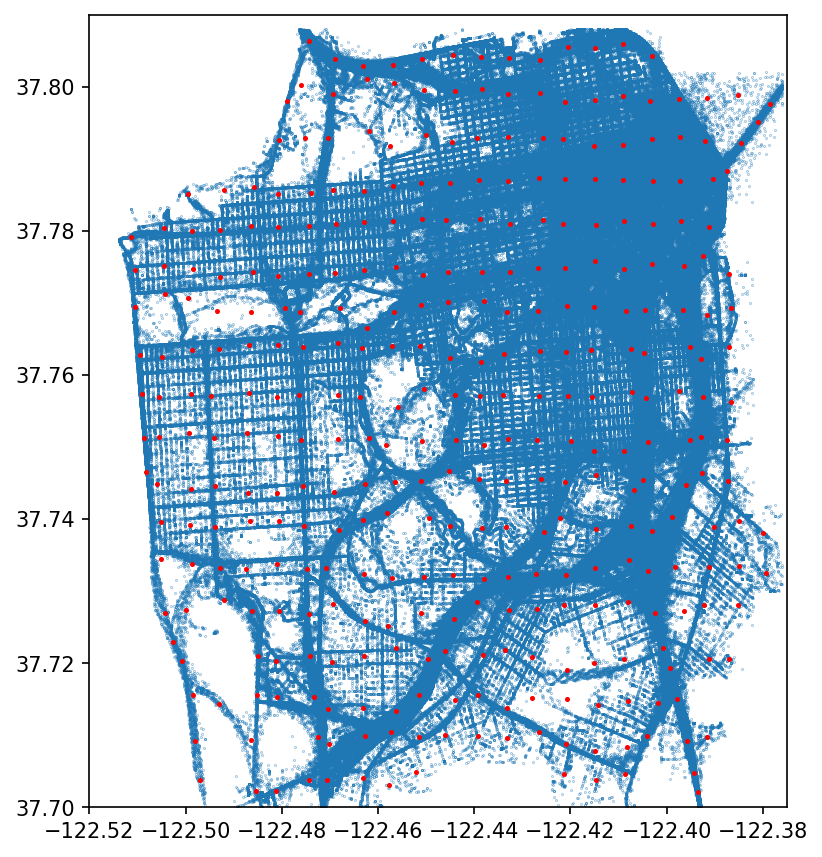

In [26]:
fig, ax = plt.subplots(figsize=(6,7), dpi=150)
ax.scatter(interpolated_df['Longitude'], interpolated_df['Latitude'], s = 0.03)
ax.scatter(np.array(nodes)[:,1], np.array(nodes)[:,0], color='red', s=2)
ax.set_ylim(latmin, latmax)
ax.set_xlim(lonmin, lonmax)

In [27]:
interpolated_df = interpolated_df.sort_values(by=['driver','trip_id','3'])

In [28]:
interpolated_df = interpolated_df.rename(columns={'2':'passenger','3':'date_time'})

In [29]:
# Function to get transitions
def get_transitions(group):
    transitions = []
    prev_node = None
    for node in group['node_id']:
        if prev_node is not None and prev_node != node:
            transitions.append((prev_node, node))
        prev_node = node
    return transitions

# Apply the function to each group
transitions = interpolated_df[['driver','trip_id','node_id']].groupby(['driver', 'trip_id']).apply(
    get_transitions)

# Flatten the transitions and create a DataFrame
transitions_list = [t for sublist in transitions for t in sublist]
transitions_df = pd.DataFrame(transitions_list, columns=['node_from', 'node_to'])

# Count the frequency
result = transitions_df.groupby(['node_from', 'node_to']).size().reset_index(name='frequency')

In [30]:
result.sort_values(by='frequency', ascending=False)

,node_from,node_to,frequency
398,65,74,22984
457,74,98,22981
290,49,65,22056
233,40,49,21893
620,98,74,20747
...,...,...,...
1179,177,217,1
1757,256,228,1
587,93,83,1
257,44,27,1


In [31]:
interpolated_df.to_csv('full_useful_trips_before.csv', index=False)

In [32]:
result.to_csv('graph_before.csv', index=False)

In [33]:
interpolated_df = pd.read_csv('full_useful_trips_before.csv')
result = pd.read_csv('graph_before.csv')

In [34]:
df_edges_to_exclude = result[result['frequency']<=3][['node_from', 'node_to']]

In [35]:
interpolated_df['node_id_shifted'] = interpolated_df.groupby(['trip_id', 'driver'])['node_id'].shift(-1)

# Merge with the edges to exclude
merged_df = pd.merge(interpolated_df, df_edges_to_exclude, 
                     left_on=['node_id', 'node_id_shifted'], 
                     right_on=['node_from', 'node_to'], 
                     how='inner')

# Get the trip_id and driver_id pairs to exclude
to_exclude = merged_df[['trip_id', 'driver']].drop_duplicates()

# Exclude these pairs from interpolated_df
filtered_df = pd.merge(interpolated_df, to_exclude, on=['trip_id', 'driver'], how='left', indicator=True)
filtered_df = filtered_df[filtered_df['_merge'] == 'left_only'].drop(columns=['node_id_shifted', '_merge'])

In [36]:
interpolated_df = filtered_df.copy()

In [37]:
result = result[result['frequency']>3]

In [38]:
nodes_df_clean = df_nodes_location[df_nodes_location['node_id'].isin(interpolated_df['node_id'].unique())].drop_duplicates(subset=['node_id'], keep='first')[['node_lon','node_lat','node_id']]

In [39]:
interpolated_df.node_id.nunique()

355

(-122.52, -122.375)

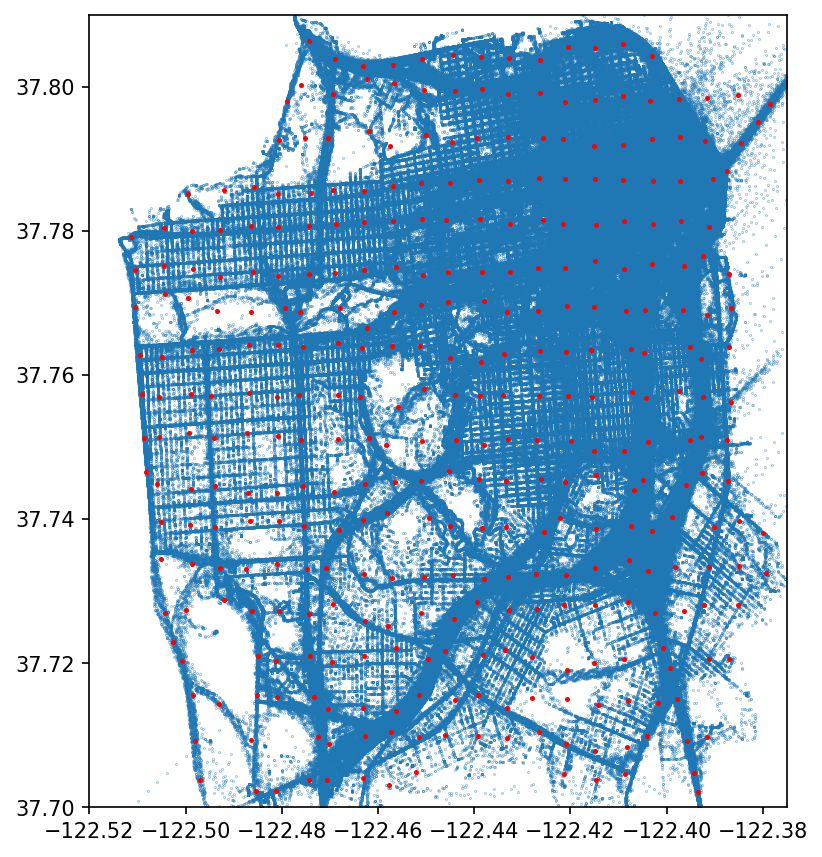

In [40]:
fig, ax = plt.subplots(figsize=(6,7), dpi=150)
ax.scatter(interpolated_df_full['Longitude'], interpolated_df_full['Latitude'], s = 0.03)
ax.scatter(nodes_df_clean['node_lon'], nodes_df_clean['node_lat'], color='red', s=2)

#ax.scatter(nodes_df_clean[nodes_df_clean['node_id'] == 326]['node_lon'], nodes_df_clean[nodes_df_clean['node_id'] == 326]['node_lat'], color='green', s=30)

ax.set_ylim(latmin, latmax)
ax.set_xlim(lonmin, lonmax)

In [41]:
def has_non_consecutive_repeat(group):
    duplicates = group[group['node_id'].duplicated(keep=False)]
    if duplicates.empty:
        return False
    consecutive_repeats = (duplicates['node_id'] == duplicates['node_id'].shift()).sum()
    return len(duplicates) > consecutive_repeats

In [42]:
interpolated_df = interpolated_df[interpolated_df.groupby(['trip_id','driver']).node_id.transform('nunique')>3]
interpolated_df = interpolated_df.sort_values(by=['driver','trip_id','date_time'])

In [43]:
interpolated_df['drop_row'] = interpolated_df.groupby(['driver', 'trip_id'])['node_id'].shift() == interpolated_df['node_id']

In [44]:
interpolated_df = interpolated_df[interpolated_df['drop_row'] == False]

In [45]:
interpolated_df.shape

(2123575, 12)

In [46]:
interpolated_df.sort_values(['driver', 'trip_id', 'date_time'], inplace=True)

global_trip_id_new = 0  # Global variable to track the new trip ID across all groups

def split_trips(group):
    global global_trip_id_new
    nodes_visited = set()
    trip_ids_new = []

    for _, row in group.iterrows():
        if row['node_id'] in nodes_visited:
            # Start a new trip
            global_trip_id_new += 1
            nodes_visited = set()
        nodes_visited.add(row['node_id'])
        trip_ids_new.append(global_trip_id_new)

    global_trip_id_new += 1  # Increment when the group ends to handle new driver or trip_id
    group['trip_id_new'] = trip_ids_new
    return group

interpolated_new = interpolated_df.groupby(['driver', 'trip_id']).apply(split_trips).reset_index(drop=True)

In [47]:
interpolated_new.shape

(2123575, 13)

In [48]:
interpolated_new = interpolated_new[interpolated_new.groupby(['trip_id_new','driver']).node_id.transform('nunique')>1]

In [49]:
interpolated_new.shape

(2112811, 13)

In [50]:
interpolated_new.columns

Index(['Latitude', 'Longitude', 'passenger', 'date_time', 'distance_km',
       'time_diff', 'trip_id', 'driver', 'node_lat', 'node_lon', 'node_id',
       'drop_row', 'trip_id_new'],
      dtype='object')

In [51]:
# Function to get transitions
def get_transitions(group):
    transitions = []
    prev_node = None
    for node in group['node_id']:
        if prev_node is not None and prev_node != node:
            transitions.append((prev_node, node))
        prev_node = node
    return transitions

# Apply the function to each group
transitions = interpolated_new[['driver','trip_id_new','node_id']].groupby(['driver', 'trip_id_new']).apply(
    get_transitions)

# Flatten the transitions and create a DataFrame
transitions_list = [t for sublist in transitions for t in sublist]
transitions_df = pd.DataFrame(transitions_list, columns=['node_from', 'node_to'])

# Count the frequency
df_edges = transitions_df.groupby(['node_from', 'node_to']).size().reset_index(name='frequency')

In [52]:
df_nodes_map = pd.DataFrame(np.array(list(enumerate(nodes_df_clean.sort_values(by='node_id').node_id.to_list()))), 
             columns=['node_id_new','node_id'])

nodes_df_clean = nodes_df_clean.merge(df_nodes_map, on='node_id')

df_edges = df_edges.merge(df_nodes_map, left_on='node_from', right_on='node_id')
df_edges['node_from_new'] = df_edges['node_id_new']
df_edges = df_edges.drop(columns=['node_id_new'])
df_edges = df_edges.merge(df_nodes_map, left_on='node_to', right_on='node_id')
df_edges['node_to_new'] = df_edges['node_id_new']
df_edges = df_edges.drop(columns=['node_id_new'])

In [53]:
df_edges.to_csv('graph_0010_080.csv', index=False)
interpolated_new.to_csv('full_useful_trips.csv', index=False)
nodes_df_clean.to_csv('nodes_0010_080.csv', index=False)